In [10]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# Charger les données prétraitées
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

# Identifier les colonnes cibles (toutes sauf la date)
target_column = df.columns[-1]

feature_columns = [col for col in df.columns if col != target_column] if len(df.columns) > 1 else [target_column]

# Dictionnaire pour stocker les prédictions
forecast_results = {}
type(df)


pandas.core.frame.DataFrame

In [ ]:
def create_features(
    df, target_column=None, lags=3, rolling_windows=[], test_size=0.2, random_state=42
):
    df = df.copy()
    lags = 3
    if target_column is None:
        target_column = df.columns[-1]

    for column in feature_columns:
        for lag in range(1, lags + 1):
            df[f"{column}_lag_{lag}"] = df[column].shift(lag)
        detected_freq = pd.infer_freq(df.index)
        print("***", detected_freq, "***")

        rolling_windows = []
        if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
            rolling_windows = [7, 14, 30]
        elif detected_freq in ["MS", "M"]:  # Mensuelle
            rolling_windows = [3, 6, 12]
        elif detected_freq in ["YS", "Y"]:  # Annuelle
            rolling_windows = [2, 3, 5]
        else:
            pass

        # Appliquer les moyennes mobiles pour detecter la saisonnalité
        for window in rolling_windows:
            df[f"rolling_mean_{window}"] = (
                df[column].shift(1).rolling(window=window).mean()
            )

        # Supprimer les valeurs NaN générées par les décalages
    df.dropna(inplace=True)
    X = df.drop(columns=[target_column], axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = create_features(df)

*** None ***
*** None ***
*** None ***


In [4]:
y_train

Period
2015-01-04          0.0
2015-01-05          0.0
2015-01-06          0.0
2015-01-07          0.0
2015-01-08          0.0
2015-01-09          0.0
2015-01-10          0.0
2015-01-11          0.0
2015-01-12          0.0
2016-01-01   -2196105.0
2016-01-02          0.0
2016-01-03          0.0
2016-01-04          0.0
2016-01-05          0.0
2016-01-06          0.0
2016-01-07          0.0
2016-01-08          0.0
2016-01-09          0.0
2016-01-10          0.0
2016-01-11          0.0
2016-01-12          0.0
2017-01-01    -422098.0
2017-01-02          0.0
2017-01-03          0.0
2017-01-04          0.0
2017-01-05          0.0
2017-01-06          0.0
2017-01-07          0.0
2017-01-08          0.0
2017-01-09          0.0
2017-01-10          0.0
2017-01-11          0.0
2017-01-12          0.0
2018-01-01     791374.0
2018-01-02          0.0
2018-01-03          0.0
2018-01-04          0.0
2018-01-05          0.0
2018-01-06          0.0
2018-01-07          0.0
2018-01-08          0.0
2018-01-0

In [5]:
def train_xgboost_timeseries():
    """
    Train XGBoost model for multivariate time series prediction
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input time series DataFrame
    date_column : str, optional
        Name of the date column
    target_column : str or list, optional
        Column(s) to predict
    time_steps : int, optional
        Number of previous time steps to use as features
    test_size : float, optional
        Proportion of data to use for testing
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    dict: Contains model, test data, predictions, and evaluation metrics
    """
    # Create features and target

    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Prepare DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    
    # Define XGBoost parameters
    params = {
        'objective': 'reg:squarederror',  # Regression objective
        'eval_metric': 'rmse',  # Root Mean Squared Error
        'max_depth': 5,
        'learning_rate': 0.1,
        'n_estimators': 150
    }
    
    # Train the model
    model = xgb.train(
        params, 
        dtrain, 
        num_boost_round=100,
        evals=[(dtest, 'test')],
        early_stopping_rounds=10,
        verbose_eval=10
    )
    
    # Make predictions
    predictions = model.predict(dtest)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test,predictions)
    
    return {
        'model': model,
        'predictions': predictions,
        'mse': mse,
        'mae': mae,
        "r2": r2,
        'scaler': scaler
    }

In [6]:
results = train_xgboost_timeseries()


[0]	test-rmse:253344.78290
[9]	test-rmse:377617.18492


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [22:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


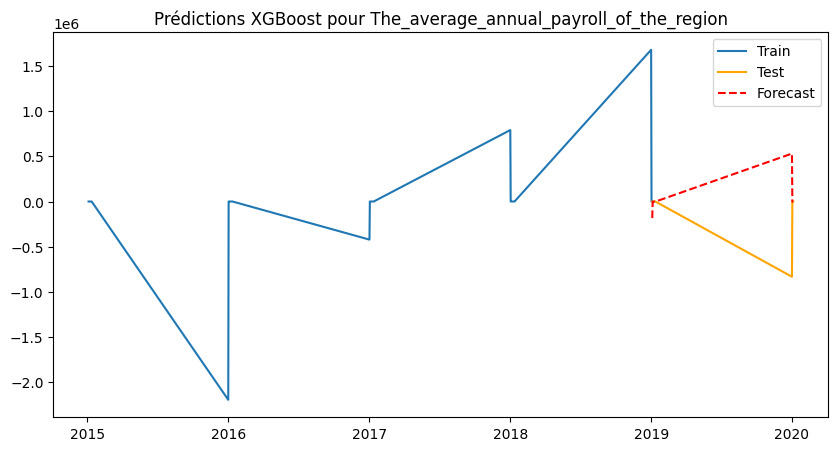

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test", color="orange")
plt.plot(y_test.index, results['predictions'], label="Forecast", linestyle="dashed", color="red")
plt.title(f"Prédictions XGBoost pour {target_column}")
plt.legend()
plt.show()
df1=pd.DataFrame({target_column : results["predictions"]}, index=y_test.index)
df1.to_csv(f"forecast_xgboost_{target_column}.csv", index=False)

In [8]:
results["r2"]

-1.9554583859074723

In [9]:
def OldXGBoost(df, target_columns):    
    for column in target_columns:
        print(f"Training XGBoost model for {column}...")

        # Créer les features
        data = create_features(df, column)

        # Séparer les features (X) et la cible (y)
        X = data.drop(columns=[column])
        y = data[column]

        # Séparer Train/Test (80% - 20%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Entraîner le modèle XGBoost
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
        model.fit(X_train, y_train)

        # Faire des prédictions
        y_pred = model.predict(X_test)

        # Calculer l'erreur
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for {column}: {mse:.4f}")

        # Sauvegarder les résultats
        forecast_results[column] = pd.DataFrame({"ds": X_test.index, "yhat": y_pred})

        # Visualisation
        plt.figure(figsize=(10, 5))
        plt.plot(y_train.index, y_train, label="Train")
        plt.plot(y_test.index, y_test, label="Test", color="orange")
        plt.plot(y_test.index, y_pred, label="Forecast", linestyle="dashed", color="red")
        plt.title(f"Prédictions XGBoost pour {column}")
        plt.legend()
        plt.show()

    # Sauvegarder les prévisions
    for col, forecast in forecast_results.items():
        forecast.to_csv(f"forecast_xgboost_{col}.csv", index=False)

    print("Toutes les prédictions XGBoost ont été enregistrées.")
